In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ

from qiskit.tools.jupyter import *

from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

from qiskit.utils import QuantumInstance

from qiskit.circuit import Parameter

# Storing results in a dictionary
from qiskit.transpiler import PassManager
# Unroller transpile our circuit into CNOTs and U gates
from qiskit.transpiler.passes import Unroller

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Chemistry Drivers
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.drivers import UnitsType

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit.opflow.primitive_ops import Z2Symmetries

# Electroinic structure problem
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Qubit converter
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Mappers
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper

# Initial state
from qiskit_nature.circuit.library import HartreeFock, UCCSD

# Variational form - circuit
from qiskit.circuit.library import TwoLocal

# Optimizer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

# Algorithms and Factories
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory, VQEUCCFactory

# Eigen Solvers
# NumPy Minimum Eigen Solver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
# ground state
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
# VQE Solver
from qiskit.algorithms import VQE

In [3]:
state_sim = StatevectorSimulator()
qasm_sim = QasmSimulator()

In [4]:
def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

In [5]:
counts = []
values = []
params = []
deviation = []

numpy_exact_result = []

ry_result_dict = {}
ryrz_result_dict = {}
uccsd_result_dict = {}
a_result_dict = {}
at_result_dict = {}


ry_iterations = [] #counts
ry_energies = [] # values
ry_params = [] # params
ry_deviation = [] # deviations

ryrz_iterations = [] #counts
ryrz_energies = [] # values
ryrz_params = [] # params
ryrz_deviation = [] # deviations

uccsd_iterations = [] #counts
uccsd_energies = [] # values
uccsd_params = [] # params
uccsd_deviation = [] # deviations

a_iterations = [] #counts
a_energies = [] # values
a_params = [] # params
a_deviation = [] # deviations

at_iterations = [] #counts
at_energies = [] # values
at_params = [] # params
at_deviation = [] # deviations

In [6]:
class MolecularVQE:
    def __init__(self):
        # H2
        self.molecule_name = "Li 0.0 0.0 0.0; H 0.0 0.0 "
        self.backend = QuantumInstance(qasm_sim)
        self.optimizer = self.get_optimizer("COBYLA")
        self.mapper = self.get_mapper("pa")
        
    def get_mapper(self, mapper_str: str):
        if mapper_str == "jw":
            return JordanWignerMapper()
        elif mapper_str == "pa":
            return ParityMapper()
        elif mapper_str == "bk":
            return BravyiKitaevMapper()
    
    
    def get_optimizer(self, optimizer_name: str):
        if optimizer_name == "SLSQP":
            return SLSQP(maxiter=500)
        elif optimizer_name == "COBYLA":
            return COBYLA(maxiter=10000)
    
    
    def exact_diagonalizer(self, es_problem, qubit_converter):
        solver = NumPyMinimumEigensolverFactory()
        calc = GroundStateEigensolver(qubit_converter, solver)
        self.exact_result = calc.solve(es_problem)
        return self.exact_result
    
    
    def prepare_init_state(self):
        self.init_state = HartreeFock(self.num_spin_orbitals, self.num_particles, self.qubit_converter)
        self.init_state.barrier()

        # self.init_state.draw("mpl", initial_state=True).savefig("h2_init_state.png", dpi=300)
        # self.init_state.draw("mpl", initial_state=True)


        
    def initial_state_preparation(self, dist: float):
        self.molecule = self.molecule_name + str(dist)
        self.driver = PySCFDriver(
            atom=self.molecule,
            unit = UnitsType.ANGSTROM,
            basis = "sto3g"
        )
        self.qmolecule = self.driver.run()

        transformer = FreezeCoreTransformer()
        self.qmolecule = transformer.transform(self.qmolecule)
        self.es_problem = ElectronicStructureProblem(self.driver)

        # generating second_quzntized operators
        self.second_q_ops = self.es_problem.second_q_ops()

        # Hamiltonian
        self.main_op = self.second_q_ops[0]

        # return tuple of number of particles if available
        self.num_particles = self.es_problem.num_particles
        # return the number of spin orbitals
        self.num_spin_orbitals = self.es_problem.num_spin_orbitals

        self.qubit_converter = QubitConverter(mapper=self.mapper, two_qubit_reduction=True, z2symmetry_reduction=[1, 1])

        # Qubit Hamiltonian
        self.qubit_op = self.qubit_converter.convert(self.main_op, num_particles=self.num_particles)

        return (self.qubit_op, self.num_particles, self.num_spin_orbitals, self.qubit_converter, self.es_problem)
        
    
    def solver(self, result, citerations, cenergies, cparams, cdeviation):
        try:
            initial_point = [0.01] * len(self.ansatz.ordered_parameters)
        except:
            initial_point = [0.01] * self.ansatz.num_parameters

        self.algorithm = VQE(
            self.ansatz,
            optimizer=self.optimizer,
            quantum_instance=state_sim,
            callback=callback,
            initial_point=initial_point)
        try:
            result = self.algorithm.compute_minimum_eigenvalue(self.qubit_op)
        except:
            calc = GroundStateEigensolver(self.qubit_converter, vqe_solver)
            result = calc.solve(self.es_problem)
            
        citerations.clear()
        cenergies.clear()
        cparams.clear()
        cdeviation.clear()
        for i in range(len(counts)):
            citerations.append(counts[i])
            cenergies.append(values[i])
            cparams.append(params[i])
            cdeviation.append(deviation[i])
        counts.clear()
        values.clear()
        params.clear()
        deviation.clear()

        print("\nResults:\n")
        print(result)
        # ry_result.clear()
        # ry_result.append(self.ry_result)
        
        self.circuit_data(result)
        
    def ucc_solver(self, result, citerations, cenergies, cparams, cdeviation):
        try:
            initial_point = [0.01] * len(self.ansatz.ordered_parameters)
        except:
            initial_point = [0.01] * self.ansatz.num_parameters

        vqe_solver = VQEUCCFactory(
            quantum_instance=self.backend,
            optimizer=self.optimizer,
            initial_point=initial_point,
            ansatz=self.ansatz,
            initial_state=self.init_state,
            callback=callback
        )
        
        calc = GroundStateEigensolver(self.qubit_converter, vqe_solver)
        result = calc.solve(self.es_problem)
        
        citerations.clear()
        cenergies.clear()
        cparams.clear()
        cdeviation.clear()
        for i in range(len(counts)):
            citerations.append(counts[i])
            cenergies.append(values[i])
            cparams.append(params[i])
            cdeviation.append(deviation[i])
        counts.clear()
        values.clear()
        params.clear()
        deviation.clear()

        print("\nResults:\n")
        print(result)
        # ry_result.clear()
        # ry_result.append(self.ry_result)
        
        self.circuit_data(result)
        
        
    def circuit_data(self, result):
        pass_ = Unroller(['u', 'cx'])
        pm = PassManager(pass_)
        ansatz_tp = pm.run(self.ansatz)
        cnots = ansatz_tp.count_ops()['cx']
        score = cnots
        accuracy_threshold = 4.0 # in mHa
        try:
            energy = result.optimal_value
        except:
            energy = np.real(result.eigenenergies)
            
        # numpy_exact_result = numpy_exact_result[0]
# numpy_exact_energy = np.real(numpy_exact_result.eigenenergies[0])
            
        exact_energy = np.real(self.exact_result.eigenenergies[0])
        
        self.result_dict = {
            'optimizer': self.optimizer.__class__.__name__,
            'mapping': self.qubit_converter.mapper.__class__.__name__,
            'ansatz': self.ansatz_type + "-" + self.ansatz.__class__.__name__,
            'rotation_blocks': self.rotation_blocks,
            'entanglement_blocks': self.entanglement_blocks,
            'entanglement': self.ansatz.entanglement,
            'repetitions': self.ansatz.reps,#repetitions,
            # 'skip_final_rotation_layer': self.ansatz.skip_final_rotation_layer,
            'energy (Ha)': energy,
            'error (mHa)': (energy-exact_energy)*1000,
            'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
            '# of parameters': len(result.optimal_point),
            'final_parameters': result.optimal_point,
            '# of evaluations': result.optimizer_evals,
            'optimizer_time': result.optimizer_time,
            '# of qubits': int(self.qubit_op.num_qubits),
            '# of CNOTs': cnots,
            'score': score
        }
        
    
    def ry_ansatz(self):
        # Setting up TwoLocal for our ansatz
        self.ansatz_type = "RY"

        # Single qubit rotations that are placed on all qubits with independent parameters
        self.rotation_blocks = ["ry"]
        # Entangling gates
        self.entanglement_blocks = ["cx"]
        # How the qubits are entangled?
        entanglement = 'linear'
        # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
        repetitions = 2
        # Skipoing the final rotation_blocks layer
        skip_final_rotation_layer = False

        self.ansatz = TwoLocal(
            self.qubit_op.num_qubits,
            self.rotation_blocks,
            self.entanglement_blocks,
            reps=repetitions,
            entanglement=entanglement,
            skip_final_rotation_layer=skip_final_rotation_layer,
            # insert_barriers=True,
            name="RY"
        )

        # Add the initial state
        self.ansatz.compose(self.init_state, front=True, inplace=True)
        # self.ansatz.decompose().draw(output="mpl", initial_state=True).savefig("ry_vqe_h2_ansatz_decomposed.png", dpi=300)
        
        
    def ryrz_ansatz(self):
        # Setting up TwoLocal for our ansatz
        self.ansatz_type = "RYRZ"

        # Single qubit rotations that are placed on all qubits with independent parameters
        self.rotation_blocks = ["ry", "rz"]
        # Entangling gates
        self.entanglement_blocks = ["cx"]
        # How the qubits are entangled?
        entanglement = 'linear'
        # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
        repetitions = 2
        # Skipoing the final rotation_blocks layer
        skip_final_rotation_layer = False

        self.ansatz = TwoLocal(
            self.qubit_op.num_qubits,
            self.rotation_blocks,
            self.entanglement_blocks,
            reps=repetitions,
            entanglement=entanglement,
            skip_final_rotation_layer=skip_final_rotation_layer,
            # insert_barriers=True,
            name="RYRZ"
        )

        # Add the initial state
        self.ansatz.compose(self.init_state, front=True, inplace=True)
        # self.ansatz.decompose().draw(output="mpl", initial_state=True).savefig("ryrz_vqe_h2_ansatz_decomposed.png", dpi=300)
    
    
    def uccsd_ansatz(self):
        # Setting up TwoLocal for our ansatz
        self.ansatz_type = "UCCSD"
        # Single qubit rotations that are placed on all qubits with independent parameters
        self.rotation_blocks = None
        # Entangling gates
        self.entanglement_blocks = None
        # How the qubits are entangled?
        entanglement = None
        # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
        repetitions = None
        # Skipoing the final rotation_blocks layer
        skip_final_rotation_layer = None

        self.ansatz = UCCSD(
            qubit_converter=self.qubit_converter,
            num_particles=self.num_particles,
            num_spin_orbitals=self.num_spin_orbitals,
            reps=1,
            initial_state=self.init_state,
        )

        self.ansatz.compose(self.init_state, front=True, inplace=True)
    
    
    def A_ansatz(self):
        theta = Parameter("t")
        phi = Parameter("p")

        R = QuantumCircuit(1, name="$R(\\theta, \phi)$")
        R.ry(theta + (0.5 * np.pi), 0)
        R.rz(phi + np.pi, 0)

        Rd = QuantumCircuit(1, name="$R(\\theta, \phi)^\dagger$")
        Rd.ry(theta + (0.5 * np.pi), 0).inverse()
        Rd.rz(phi + np.pi, 0).inverse()

        a_var_form = QuantumCircuit(2)#self.qubit_op.num_qubits)
        a_var_form.cx(1, 0)
        a_var_form.append(Rd, [1])
        a_var_form.cx(0, 1)
        a_var_form.append(R, [1])
        a_var_form.cx(1, 0)
        
        self.ansatz_type = "$A(\\theta, \phi)$"

        self.ansatz = TwoLocal(
            num_qubits = self.qubit_op.num_qubits,
            rotation_blocks = [ a_var_form ],
            entanglement_blocks = [ a_var_form ],
            entanglement = [[1, 2], [3, 4], [5, 6]],
            reps=2,
            skip_unentangled_qubits = False,
            skip_final_rotation_layer = True,
            # parameter_prefix = theta,
            insert_barriers = False,
            # initial_state = init_state,
            name = "$A(\\theta, \phi)$"
        )

        self.ansatz.compose(self.init_state, front=True, inplace=True)
        
    def AT_ansatz(self):
        theta = Parameter("t")
        # phi = Parameter("p")

        R = QuantumCircuit(1, name="$R(\\theta, \phi)$")
        R.ry(theta + (0.5 * np.pi), 0)
        R.rz(0 + np.pi, 0)

        Rd = QuantumCircuit(1, name="$R(\\theta, \phi)^\dagger$")
        Rd.ry(theta + (0.5 * np.pi), 0).inverse()
        Rd.rz(0 + np.pi, 0).inverse()

        a_var_form = QuantumCircuit(2)#self.qubit_op.num_qubits)
        a_var_form.cx(1, 0)
        a_var_form.append(Rd, [1])
        a_var_form.cx(0, 1)
        a_var_form.append(R, [1])
        a_var_form.cx(1, 0)

        self.ansatz_type = "$AT(\\theta, \phi)$"

        self.ansatz = TwoLocal(
            num_qubits = self.qubit_op.num_qubits,
            rotation_blocks = [ a_var_form ],
            entanglement_blocks = [ a_var_form ],
            entanglement = [[1, 2], [3, 4], [5, 6]],
            reps=2,
            skip_unentangled_qubits = False,
            skip_final_rotation_layer = True,
            # parameter_prefix = theta,
            insert_barriers = False,
            # initial_state = init_state,
            name = "$AT(\\theta, \phi)$"
        )

        self.ansatz.compose(self.init_state, front=True, inplace=True)

    
    def execute(self):
        # self.qubit_op, self.num_particles, self.num_spin_orbitals, self.qubit_converter, self.es_problem = self.initial_state_preparation( dist="0.735" )
        self.initial_state_preparation( dist="1.5474" )
        self.prepare_init_state()
        print(self.init_state)
        
        self.exact_diagonalizer(self.es_problem, self.qubit_converter)
        # from time import sleep
        print(np.real(self.exact_result.eigenenergies[0]))
        # sleep(5)
        numpy_exact_result.clear()
        numpy_exact_result.append(self.exact_result)        
        
        
        # ry solver
        self.ry_ansatz()
        print(self.ansatz)
        print(self.ansatz.decompose())
        self.ry_result = 0
        self.solver(self.ry_result, ry_iterations, ry_energies, ry_params, ry_deviation)
        for e in self.result_dict:
            ry_result_dict[e] = self.result_dict[e]
        self.result_dict.clear()
        
        # ryrz solver
        self.ryrz_ansatz()
        print(self.ansatz)
        print(self.ansatz.decompose())
        self.ryrz_result = 0
        self.solver(self.ryrz_result, ryrz_iterations, ryrz_energies, ryrz_params, ryrz_deviation)
        for e in self.result_dict:
            ryrz_result_dict[e] = self.result_dict[e]
        self.result_dict.clear()
        
        # uccsd solver
        self.uccsd_ansatz()
        print(self.ansatz)
        print(self.ansatz.decompose())
        self.uccsd_result = 0
        self.solver(self.uccsd_result, uccsd_iterations, uccsd_energies, uccsd_params, uccsd_deviation)
        for e in self.result_dict:
            uccsd_result_dict[e] = self.result_dict[e]
        self.result_dict.clear()
        
        # AP solver
        self.A_ansatz()
        print(self.ansatz)
        print(self.ansatz.decompose())
        self.a_result = 0
        self.solver(self.a_result, a_iterations, a_energies, a_params, a_deviation)
        for e in self.result_dict:
            a_result_dict[e] = self.result_dict[e]
        self.result_dict.clear()
        
        # AT solver
        self.AT_ansatz()
        print(self.ansatz)
        print(self.ansatz.decompose())
        self.at_result = 0
        self.solver(self.at_result, at_iterations, at_energies, at_params, at_deviation)
        for e in self.result_dict:
            at_result_dict[e] = self.result_dict[e]
        self.result_dict.clear()
        

In [7]:
vqesolver = MolecularVQE()
vqesolver.execute()


Results:

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 200,
    'eigenstate': array([ 2.59349308e-20-3.86136289e-20j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  1.11487882e-05-5.91596743e-17j,
        0.00000000e+00+0.00000000e+00j,  1.99374429e-06+7.90298863e-17j,
       -8.25600878e-09+4.35308373e-20j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  9.99999808e-01+1.21402314e-15j,
       -2.02539698e-05+7.89746674e-17j,  0.00000000e+00+0.00000000e+00j,
        6.19270710e-04+6.01546300e-17j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -2.47369058e-17+4.29138591e-17j,
        0.00000000e+00+0.00000000e+00j,  1.13599284e-05-9.33483935e-17j,
       -3.49184571e-10+2.39766392e-21j,  0.00000000e+00+0.00000000e+00j,
        1.95683203e-08-1.61250420e-20j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -8.83713020e-22+1.16878940e-22j,
        3.38193764e-14-2.

In [8]:
numpy_exact_result = numpy_exact_result[0]
numpy_exact_energy = np.real(numpy_exact_result.eigenenergies[0])

print("\nExact Electronic Energy: {:.4f} Eh\n\n".format(numpy_exact_energy))
print("Results:\n\n", numpy_exact_result)


Exact Electronic Energy: -8.9087 Eh


Results:

 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.908697116424
  - computed part:      -8.908697116424
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.882762236781
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 


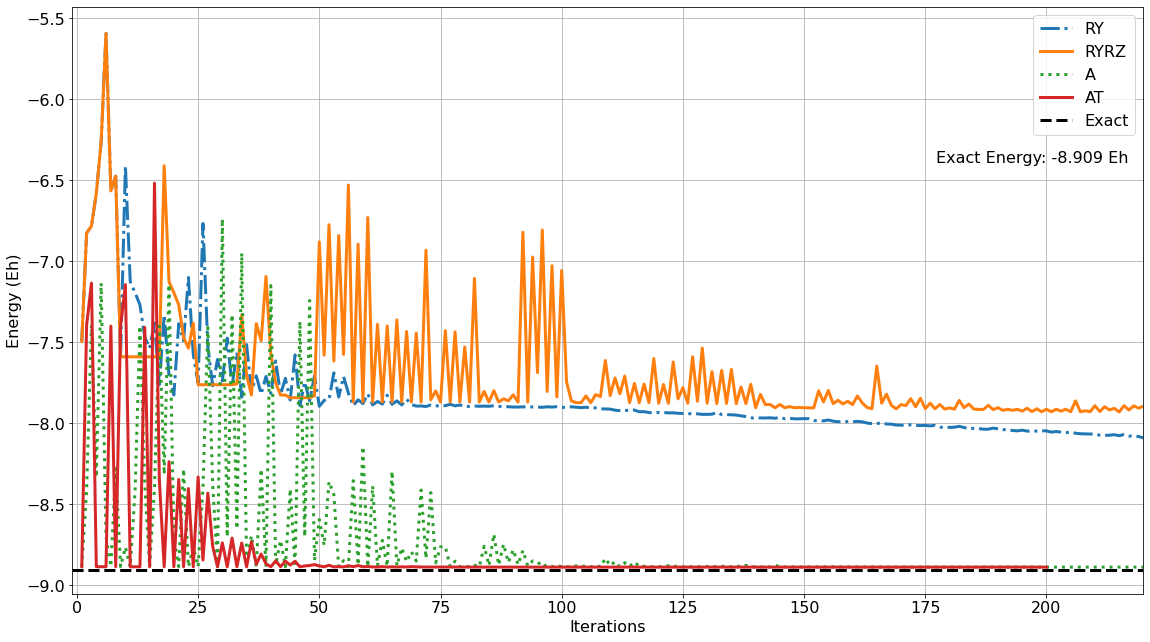

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
# plt.title("Ground State Energy of $LiH$ Molecule\t-\tParity Mapper")

fig.text(0.75, 0.68, f'Exact Energy: {numpy_exact_energy:.3f} Eh')

plt.rc('font', size=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)

plt.xlim([-1, 220])

# ax.set_facecolor("#293952")
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Eh)')
ax.grid()

ax.plot(ry_iterations, ry_energies, label="RY", linewidth=3, linestyle="-.")
ax.plot(ryrz_iterations, ryrz_energies, label="RYRZ", linewidth=3, linestyle=None)
# ax.plot(uccsd_iterations, uccsd_energies, label="UCCSD", linewidth=3, linestyle="--")
ax.plot(a_iterations, a_energies, label="A", linewidth=3, linestyle=":")
ax.plot(at_iterations, at_energies, label="AT", linewidth=3, linestyle=None)
ax.axhline(numpy_exact_energy, linestyle='--', label="Exact", color="#000000", linewidth=3)

plt.legend()

fig.savefig("vqe_lih_pa_all.png", dpi=200)

In [10]:
print("RY DATA")
ry_result_df = pd.DataFrame.from_dict([ry_result_dict])
ry_result_df[["optimizer", "mapping", "ansatz", "rotation_blocks", "entanglement_blocks", "entanglement", "energy (Ha)", "error (mHa)",
           "# of parameters", "optimizer_time", "# of qubits", "# of CNOTs", "pass"]]

RY DATA


,optimizer,mapping,ansatz,rotation_blocks,entanglement_blocks,entanglement,energy (Ha),error (mHa),# of parameters,optimizer_time,# of qubits,# of CNOTs,pass
0,COBYLA,ParityMapper,RY-TwoLocal,[ry],[cx],linear,-8.889058,19.639097,24,116.516854,8,14,False


In [11]:
print("RYRZ DATA")
ryrz_result_df = pd.DataFrame.from_dict([ryrz_result_dict])
ryrz_result_df[["optimizer", "mapping", "ansatz", "rotation_blocks", "entanglement_blocks", "entanglement", "energy (Ha)", "error (mHa)",
           "# of parameters", "optimizer_time", "# of qubits", "# of CNOTs", "pass"]]

RYRZ DATA


,optimizer,mapping,ansatz,rotation_blocks,entanglement_blocks,entanglement,energy (Ha),error (mHa),# of parameters,optimizer_time,# of qubits,# of CNOTs,pass
0,COBYLA,ParityMapper,RYRZ-TwoLocal,"[ry, rz]",[cx],linear,-8.369846,538.851455,48,210.416522,8,14,False


In [12]:
print("UCCSD DATA")
uccsd_result_df = pd.DataFrame.from_dict([uccsd_result_dict])
uccsd_result_df[["optimizer", "mapping", "ansatz", "rotation_blocks", "entanglement_blocks", "entanglement", "energy (Ha)", "error (mHa)",
           "# of parameters", "optimizer_time", "# of qubits", "# of CNOTs", "pass"]]

UCCSD DATA


,optimizer,mapping,ansatz,rotation_blocks,entanglement_blocks,entanglement,energy (Ha),error (mHa),# of parameters,optimizer_time,# of qubits,# of CNOTs,pass
0,COBYLA,ParityMapper,UCCSD-UCCSD,None,None,None,-1.959500e-14,8908.697116,34,74.735808,8,1864,False


In [13]:
print("A DATA")
a_result_df = pd.DataFrame.from_dict([a_result_dict])
a_result_df[["optimizer", "mapping", "ansatz", "rotation_blocks", "entanglement_blocks", "entanglement", "energy (Ha)", "error (mHa)",
           "# of parameters", "optimizer_time", "# of qubits", "# of CNOTs", "pass"]]

A DATA


,optimizer,mapping,ansatz,rotation_blocks,entanglement_blocks,entanglement,energy (Ha),error (mHa),# of parameters,optimizer_time,# of qubits,# of CNOTs,pass
0,COBYLA,ParityMapper,"$A(\theta, \phi)$-TwoLocal",None,None,"[(1, 2), (3, 4), (5, 6)]",-8.889048,19.649524,28,17.686747,8,42,False


In [14]:
print("AT DATA")
at_result_df = pd.DataFrame.from_dict([at_result_dict])
at_result_df[["optimizer", "mapping", "ansatz", "rotation_blocks", "entanglement_blocks", "entanglement", "energy (Ha)", "error (mHa)",
           "# of parameters", "optimizer_time", "# of qubits", "# of CNOTs", "pass"]]

AT DATA


,optimizer,mapping,ansatz,rotation_blocks,entanglement_blocks,entanglement,energy (Ha),error (mHa),# of parameters,optimizer_time,# of qubits,# of CNOTs,pass
0,COBYLA,ParityMapper,"$AT(\theta, \phi)$-TwoLocal",None,None,"[(1, 2), (3, 4), (5, 6)]",-8.88905,19.647419,14,3.181128,8,42,False
